# Homework 2

Ben Smith

ECON 213R

10/13/18

We will test several models to estimate housing prices for Kaggle's test set. First, after we take a look at our data and clean it a little, we use a couple models discussed in class. After that, we will also try a model based on several kernels that are available on Kaggle. In the end, we will take a look at which ones seem best and create a model based on the best-performing ones we tried.

I thank Professor Folkman, as well as Serigne, Pedro Marcelino, DanB, and Hyun Woo Kim from Kaggle for inspiring important parts of my code.

Some links to their work are:

Professor Folkman's GitHub: https://github.com/tfolkman/byu_econ_applied_machine_learning/tree/master/lectures 

Serigne's kernel: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

Pedro Marcelino's kernel: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

DanB's kernels: https://www.kaggle.com/dansbecker/xgboost and https://www.kaggle.com/dansbecker/submitting-from-a-kernel

Hyun Woo Kim's kernel: https://www.kaggle.com/chocozzz/week1-exploratory-data-analysis-with-pyhton/notebook

First, let's import the modules we'll need, as well as our data.

In [454]:
import os
import pandas as pd
from sklearn.linear_model import SGDRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from xgboost import XGBRegressor
%matplotlib inline

In [455]:
wrkdir = 'C:/Users//Ben Smith//Downloads'

os.chdir(wrkdir)

trainfile = pd.read_csv('train.csv')
testfile = pd.read_csv('test.csv')

In [456]:
#Let's check that our train file and test file look good
trainfile[:3]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [457]:
testfile[:3]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


Now, let's clean and scale our variables. After that, we will look at our data through several lenses and then run a simple regression to see which variables seem to affect prices the most in our training file.

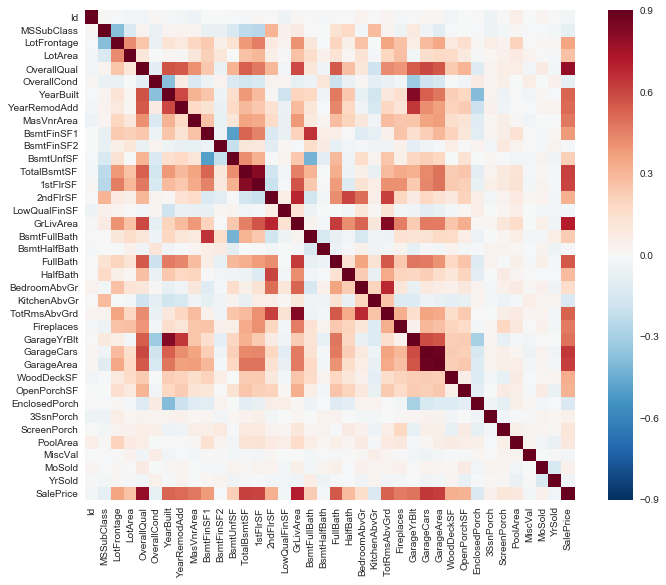

In [458]:
#First, before we set numbers for all our variables, lets look at how our numeric variables correlate with prices
corrmat = trainfile.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

It appears off the bat that out of our numerical variables, Overall Quality has the highest correlation with price.

In [459]:
#Now before scaling, we have to give numerical values to our categorical variables, as well as all others
#This file contains only ints, floats, and objects. Make dummy variables out of objects.

trainfile = pd.get_dummies(trainfile)

trainfile[:3]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0


In [460]:
#Let's describe our data from the training file

trainfile['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

At least there don't seem to be any negative prices, and the max is believable. However, it turns out that there are missing values. Let's see where they are.

In [461]:
"""
trainfile_na = (trainfile.isnull().sum() / len(trainfile)) * 100
trainfile_na = trainfile_na.drop(trainfile_na[trainfile_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :trainfile_na})
missing_data.head(20)
"""

"\ntrainfile_na = (trainfile.isnull().sum() / len(trainfile)) * 100\ntrainfile_na = trainfile_na.drop(trainfile_na[trainfile_na == 0].index).sort_values(ascending=False)[:30]\nmissing_data = pd.DataFrame({'Missing Ratio' :trainfile_na})\nmissing_data.head(20)\n"

In [462]:
for col in trainfile:
    if trainfile[col].isnull().values.any():
        print(col)

LotFrontage
MasVnrArea
GarageYrBlt


In [463]:
#There are missing values in three columns shown above. How many?

for col in trainfile:
    if trainfile[col].isnull().values.any():
        print(trainfile[col].isnull().values.sum())

259
8
81


There are a total of 259 observations in LotFrontage without values. There are others, though fewer, in MasVnrArea and GarageYrBlt. In every case other than LotFrontage, well over 90% of potential values for each variable is present. Thus, as those missing values also  appear random, I feel confident that replacing them with their respective medians will not have a significant effect. It is most likely that the houses with the missing values reflect the median houses in the area, on average.

With respect to LotFrontage, I replace missing values with the median value as well, for similar reasons.

On Kaggle, there are a lot of kernels that consider NA as missing data in the case of PoolQC and other variables, where NA means "none" (no pools, etc.). I'm not convinced, however that NA should be treated as missing data, since knowing whether or not a house has a pool or whatever it is could potentially be important for our model.

In [464]:
for col in trainfile:
    trainfile[col] = trainfile[col].fillna(trainfile[col].median())
trainfile[:3]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0


Let's create a new variable for total sq. footage, which Serigne notes is missing.

In [465]:
trainfile['TotalSF'] = trainfile['TotalBsmtSF'] + trainfile['1stFlrSF'] + trainfile['2ndFlrSF']

There are also outliers in the dataset. Let's take a look at a couple glaring outliers in GrLivArea.

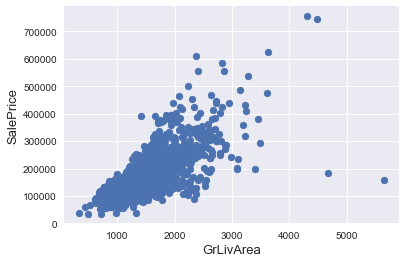

In [466]:
fig, ax = plt.subplots()
ax.scatter(x = trainfile['GrLivArea'], y = trainfile['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Since there are only two outliers and they have huge GrLivAreas and extremely low prices, we can and should drop them. I conclude that we can drop them because two observations' absence shouldn't affect the dataset of more than 1400 hardly at all. Also, we should drop these outliers because they have huge aboveground living areas with respect to their low prices. No other houses are that cheap and still have as much living area above or below ground. Thus, it is quite likely that there is something wrong with these houses. Either they are registered with the wrong numbers for GrLivAreas, or there is something abnormal that makes these houses terrible places to live (they are haunted, or they have huge worms in their water, or something like that), or these two houses may be fake listings (a common occurance in Provo, for example). In any case, these two houses appear to be part of some other distribution. Thus, we drop them.

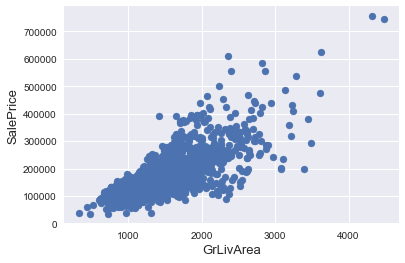

In [467]:
#Delete outliers
trainfile = trainfile.drop(trainfile[(trainfile['GrLivArea']>4000) & (trainfile['SalePrice']<300000)].index)

#Check the graph one more time
fig, ax = plt.subplots()
ax.scatter(trainfile['GrLivArea'], trainfile['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

That looks better. Now we scale variables.

In [468]:
#Scale variables

scaler = StandardScaler()
s_trainfile = scaler.fit_transform(trainfile)

s_trainfile #I have checked and this array has near 0 mean and 1 std. dev. for every variable

array([[-1.73031138,  0.07342554, -0.22132801, ...,  0.46586305,
        -0.3035372 ,  0.01143614],
       [-1.72793866, -0.87186754,  0.49176031, ...,  0.46586305,
        -0.3035372 , -0.04283834],
       [-1.72556594,  0.07342554, -0.07871034, ...,  0.46586305,
        -0.3035372 ,  0.19235109],
       ..., 
       [ 1.72674416,  0.30974881, -0.17378878, ...,  0.46586305,
        -0.3035372 ,  1.20805931],
       [ 1.72911688, -0.87186754, -0.07871034, ...,  0.46586305,
        -0.3035372 , -0.51838621],
       [ 1.7314896 , -0.87186754,  0.2540642 , ...,  0.46586305,
        -0.3035372 , -0.05834534]])

Let's clean the test file's variables too.

In [469]:
testfile = pd.get_dummies(testfile)

testfile[:3]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0


In [470]:
#Are there any missing values?

for col in testfile:
    if testfile[col].isnull().values.any():
        print(col)

LotFrontage
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageCars
GarageArea


In [471]:
#There are missing values in the columns shown above. How many?

for col in testfile:
    if testfile[col].isnull().values.any():
        print(testfile[col].isnull().values.sum())

227
15
1
1
1
1
2
2
78
1
1


In [472]:
#Again, less than 10% of each column except LotFrontage is missing. Let's replace the missing values with their variables' medians as we did above.

for col in testfile:
    testfile[col] = testfile[col].fillna(testfile[col].median())
testfile[:3]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0


In [473]:
#Create total sq footage variable
testfile['TotalSF'] = testfile['TotalBsmtSF'] + testfile['1stFlrSF'] + testfile['2ndFlrSF']

In [474]:
#Scale testfile's variables

scaler = StandardScaler()
s_testfile = scaler.fit_transform(testfile)

s_testfile

array([[-1.73086406, -0.87471081,  0.56732969, ...,  0.46021084,
        -0.29936452, -0.95407224],
       [-1.72848977, -0.87471081,  0.61596272, ...,  0.46021084,
        -0.29936452,  0.16450669],
       [-1.72611547,  0.06135085,  0.27553157, ...,  0.46021084,
        -0.29936452,  0.03612434],
       ..., 
       [ 1.72611547, -0.87471081,  4.45797141, ..., -2.17291708,
        -0.29936452, -0.10242692],
       [ 1.72848977,  0.64638939, -0.30806469, ...,  0.46021084,
        -0.29936452, -0.82187655],
       [ 1.73086406,  0.06135085,  0.27553157, ...,  0.46021084,
        -0.29936452,  0.59414269]])

Now let's do some data visualization.

First, let's check out our training data's price distribution.

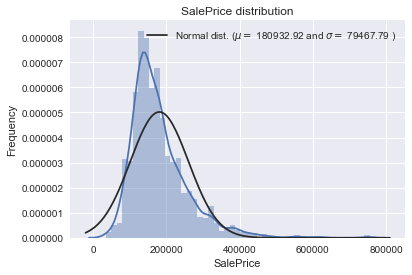

In [475]:
sns.distplot(trainfile['SalePrice'] , fit=norm);

#Get mean and std. dev.
(mu, sigma) = norm.fit(trainfile['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

Notice that this distribution is skewed. Let's try to normalize SalePrice so that regressions work better.

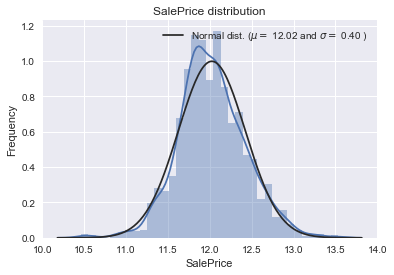

In [476]:
#log1p applies log(1+x) to all elements of the column
trainfile["SalePrice"] = np.log1p(trainfile["SalePrice"])

#Check the new distribution 
sns.distplot(trainfile['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(trainfile['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

Now it looks pretty normally distributed!

It looks like our training dataset came up with more dummies than our testing dataset. Let's look at what those extra dummies are to see if we can get rid of them.

In [477]:
for col in trainfile:
    if col not in testfile:
        print(col)

print("testfile")
for col in testfile:
    if col not in trainfile:
        print(col)

SalePrice
Utilities_NoSeWa
Condition2_RRAe
Condition2_RRAn
Condition2_RRNn
HouseStyle_2.5Fin
RoofMatl_ClyTile
RoofMatl_Membran
RoofMatl_Metal
RoofMatl_Roll
Exterior1st_ImStucc
Exterior1st_Stone
Exterior2nd_Other
Heating_Floor
Heating_OthW
Electrical_Mix
GarageQual_Ex
PoolQC_Fa
MiscFeature_TenC
testfile


I conclude that these variables can be deleted for two reasons. First, we don't have them in the test file, so they'll be useless. Second, the regression that follows doesn't indicate that any of these variables are extremely important.

In [478]:
to_delete = []
for col in trainfile:
    if col not in testfile and col != "SalePrice":
        to_delete.append(col)

for col in to_delete:
    del trainfile[col]

for col in trainfile:
    if col not in testfile:
        print(col)

SalePrice


Returning to our training dataset, let's run a regression to see what the coefficients that determine prices look like.

In [479]:
#Regression

price = trainfile["SalePrice"]

#I choose eta0 as .01 because .01 generally serves pretty well for initial models
linear_regression_model = SGDRegressor(eta0=.01)

linear_regression_model.fit(s_trainfile, price)
sorted(list(zip(trainfile.columns, linear_regression_model.coef_)), key=lambda x: abs(x[1]))

[('Exterior1st_AsphShn', 0.0),
 ('Condition2_Norm', -0.017657470872838994),
 ('Exterior1st_WdShing', 0.04934524319765133),
 ('MSZoning_FV', -0.077388777974669282),
 ('MasVnrType_Stone', -0.082074669733131711),
 ('HouseStyle_1Story', -0.086678841798680184),
 ('BldgType_1Fam', -0.086795258136609543),
 ('ExterQual_Fa', 0.090064652029277659),
 ('Condition1_RRNe', -0.095519551376294629),
 ('BsmtExposure_Mn', 0.098733133895951369),
 ('Electrical_FuseP', 0.14329784661191294),
 ('Neighborhood_Timber', -0.14488909339451186),
 ('Neighborhood_StoneBr', -0.15501710199674978),
 ('SalePrice', -0.15993480591540543),
 ('RoofStyle_Flat', -0.16313358020444479),
 ('Neighborhood_IDOTRR', -0.18199298745339954),
 ('Foundation_CBlock', 0.19911933946712396),
 ('BsmtFinType1_GLQ', 0.20466879893188783),
 ('Electrical_FuseF', 0.21737094071962018),
 ('Exterior1st_HdBoard', -0.22414240263453344),
 ('MoSold', 0.23655918869859641),
 ('Condition1_RRAn', 0.24941325596829719),
 ('HeatingQC_Gd', -0.25494737122413935),
 

Now let's split our training data into a training part and a testing part.

In [480]:
X_train, X_test, y_train, y_test = train_test_split(s_trainfile, price, test_size=0.2, random_state=42) 
#My preliminary choice of test_size is because it looks like with .2, the model does comparatively well while still having quite a large test set -- thus, giving the model more external robustness

Let's see how well a regression predicts prices in our new testing data

In [481]:
#I now choose eta0 = .001 because its MSE's come out better than for .01 and .0001
linear_regression_model = SGDRegressor(eta0=.001)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 23.382565226708373
Test MSE: 33.32503068073955


In [482]:
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html (Tyler showed us this function in class)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Ben Smith\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

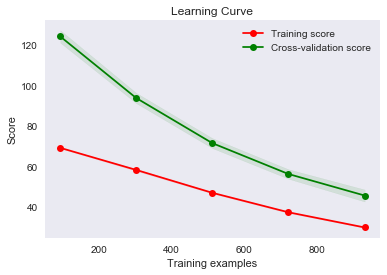

In [483]:
plot_learning_curve(linear_regression_model, "Learning Curve", X_train, y_train, cv=5)

It looks like the more training examples, the better.

This model still doesn't seem to do too perfectly, though. Let's try tweaking it.

In [484]:
#Let's see what the best eta0 is
param_dist = {"eta0": [ .0001, .001, .003, .004, .005, .006, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor()

n_iter_search = 12
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.005}
Best Negative MSE: -9.871016178227983


So, let's use eta0 = 0.004 or 0.005 from now on for Linear Regressions.

Now let's check out Elastic Net.

In [485]:
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Train MSE: 0.007733192890435347
Test MSE: 0.010481276953662199


Elastic Net seems to overfit a little, like linear regression did above. However, this Test MSE is fantastic.

Let's try K-Nearest Neighbors.

In [486]:
#Check what the best parameters and MSE are for K-Nearest Neighbors

X_train, X_test, y_train, y_test = train_test_split(trainfile, price, test_size=0.20, random_state=42)

reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Train MSE: 0.0	Test MSE: 0.04104816792192831


So, it looks like 3 is the best value for K and 1 is the best value for p. Even with these values, K-Nearest Neighbors does't predict as well as elastic net did.

Last but not least, there are some great kernels on Kaggle. Let's try one of the models other people suggest: XGBoost.

In [495]:
new_model = XGBRegressor()

new_model.fit(X_train, y_train, verbose=False)

# make predictions
predictions = new_model.predict(X_test)
mse = mean_squared_error(predictions, y_test)
print("Mean Squared Error : {}".format(mse))

Mean Squared Error : 0.00014768820886780775


This MSE is really good!!

Let's see if we can do any better by adjusting the hyperparameters.

In [496]:
#These are the parameters I'm testing
n_ops = [100, 500, 1000]
lr_ops = [0.005, 0.01, 0.05]
early_stopping_rounds_ops = [5, 10, 15]

min_mse = 100000.000

#This is a huge loop to see which parameters are best
for n in n_ops:
    for l in lr_ops:
        for s in early_stopping_rounds_ops:
            my_model = XGBRegressor(n_estimators=n, learning_rate=l)
            my_model.fit(X_train, y_train, early_stopping_rounds=s, 
                         eval_set=[(X_test, y_test)], verbose=False)
            predictions = my_model.predict(X_test)
            mse = mean_squared_error(predictions, y_test)
            min_mse = min(min_mse, mse)
            if min_mse == mse:
                best_n = n
                best_l = l
                best_s = s
                

print("min test MSE:", min_mse)
print("Best n:", best_n)
print("Best l:", best_l)
print("Best s:", best_s)

my_model = XGBRegressor(n_estimators=best_n, learning_rate=best_l)
my_model.fit(X_train, y_train, early_stopping_rounds=best_s, 
             eval_set=[(X_test, y_test)], verbose=False)

train_mse = mean_squared_error(my_model.predict(X_train), y_train)
print("train MSE", train_mse)

min test MSE: 4.88720185249e-05
Best n: 1000
Best l: 0.01
Best s: 15
train MSE 2.11296782033e-06


We seem to be overfitting a little (high variance), but this looks great. Now let's predict the prices for our test file using our modified XGBoost!

In [498]:
#X_train, y_train = train_test_split(trainfile, price, test_size=0, random_state=42)

new_model = XGBRegressor(n_estimators=best_n, learning_rate=best_l)

new_X_train = trainfile[trainfile.columns.drop('SalePrice')]

#early_stopping_rounds isn't going into this command nicely, so I'm leaving it out for now
new_model.fit(new_X_train, price, verbose=False)

#Predict
new_test_predictions = new_model.predict(testfile)

#Undo the log function we took on y near the beginning
final_predictions = np.expm1(new_test_predictions)

print("Training Mean Squared Error : {}".format(mean_squared_error(new_model.predict(new_X_train), price)))

print(final_predictions)

#Save the submission file
submission = pd.DataFrame({'Id': testfile.Id, 'SalePrice': final_predictions})

submission.to_csv('submission.csv', index=False)

Training Mean Squared Error : 0.0073298949711804815
[ 120378.9296875  161457.046875   186361.046875  ...,  154875.625
  120799.734375   235883.046875 ]


Let's see if our predictions look reasonable on a graph.

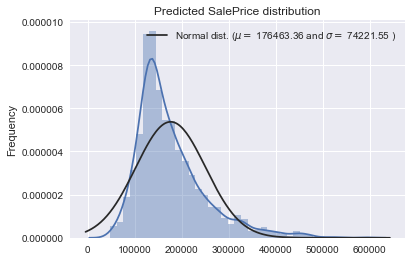

In [499]:
sns.distplot(final_predictions , fit=norm);

#Get mean and std. dev.
(mu, sigma) = norm.fit(final_predictions)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Predicted SalePrice distribution')

This distribution certainly looks a lot like the training set's price distribution!

In [500]:
#Let's look at whether there are places where this model performs poorly or exceptionally well

places = ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']

for p in places:
    str = "Neighborhood_" + p
    cond = (new_X_train[str] == 1)
    X_new = new_X_train[cond]
    y_new = price[cond]
    #for i in new_X_train['Neighborhood']:
        #if new_X_train['Neighborhood'][i] != p:
            #X_new = new_X_train[new_X_train.index.drop(i)]
            #y_new = price[price.drop(i)]
    new_predictions = new_model.predict(X_new)
    new_mse = mean_squared_error(new_predictions, y_new)
    print("MSE in ", p, ":", new_mse) 

MSE in  Blmngtn : 0.00831520356246
MSE in  Blueste : 0.00132286770237
MSE in  BrDale : 0.00434906359198
MSE in  BrkSide : 0.0079166090243
MSE in  ClearCr : 0.00988377959961
MSE in  CollgCr : 0.00424557740606
MSE in  Crawfor : 0.00630996410566
MSE in  Edwards : 0.0115303322138
MSE in  Gilbert : 0.00469707070392
MSE in  IDOTRR : 0.00892323336595
MSE in  MeadowV : 0.00527477162057
MSE in  Mitchel : 0.00714333495587
MSE in  NAmes : 0.00624809202777
MSE in  NoRidge : 0.00546785538031
MSE in  NPkVill : 0.00150117501772
MSE in  NridgHt : 0.00536165003298
MSE in  NWAmes : 0.0106006275766
MSE in  OldTown : 0.0106566633797
MSE in  SWISU : 0.00694158933353
MSE in  Sawyer : 0.0117573599978
MSE in  SawyerW : 0.00455744267052
MSE in  Somerst : 0.00787768209967
MSE in  StoneBr : 0.0107672948792
MSE in  Timber : 0.00395790431523
MSE in  Veenker : 0.00581839525028


In [501]:
#In every case, there is some slight MSE. But, the MSE's are so small that it's hard to imagine companies having very many complaints as a result of the predictions.

#In any case, the poorest predictions are in: Sawyer, Edwards, StoneBr, OldTown, and NWAmes
#The best predictions are in: Blueste, NPKVill, and Timber

## Summary

Model Selection:
    
I chose the models I did because they are not too complicated, but they are excellent for predicting in this type of scenario.

Linear regression and elastic net work by linear regression, meaning simply minimizing the sum of squared errors with a line, with a couple extra cost functions in the case of elastic net. They both assume linear independence of variables (although parameters can still go to 0 in elastic net) and normality of the y-variable's distribution.

K-nearest neighbors is a method that uses the "k" nearest neighbors to each of certain points to discover relationships between each group of neighbors. One strength of this method is that it doesn't require data to be split into a training part and a testing part. However, it assumes that distance is meaningful, which it actually isn't always when higher dimensions are used.

XGBoost, in the words of DanB, is "an implementation of the Gradient Boosted Decision Trees algorithm." Thus, it is a more advanced model that goes through cycles until it reaches the best parameters it can predict. It is best with good (not so noisy) data and it does have a possibility of overpredicting. An implicit assumption in this and the other models is that the variables are independent and identically distributed. Whether the variables in this dataset are or not is not in my control, unfortunately. So, I went with that assumption.

I cleaned the data by dealing with outliers and missing values, as well as by making the y variable normally distibuted. The "curse of Dimensionality" also shouldn't apply because we have several times more observations than variables.

My hyper-parameters were selected by the processes discussed in the code.

Model Interpretation:

The results of this model tell me that the test data looks like it is distributed similarly to the training data. 

The most influential variables in this model appear to be the following dummy variables: Utilities_AllPub (negative), LotConfig_Corner (positive), MasVnrType_BrkCmn (positive), Exterior1st_AsbShng (negative), BldgType_2fmCon (negative) and Exterior2nd_AsbShng (positive). MiscVal also tends to have a heavy positive effect.

To compensate for the somewhat high variance in my model, I could try dropping variables. However, the variance doesn't look to me like it is high enough that dropping variables would make much of a difference.

After looking at the graph of predicted prices just above, I feel very confident in my results.

Model Usefulness:
    
I think my model is very useful. I recommend using it with the parameters I found to be best (n=1000 and lr=.01). It can be used to predict housing prices in any community along the same distribution as this one.

In the cases where my model performs most poorly (although it still performs extremely well even then), I would recommend that if they are wary about estimates for those local houses, then they should maybe add an extra $4,000 (about 5% of a standard deviation) to the model's prediction, so that more often, people won't have to pay more than they expect to. However, that shouldn't be necessary, since the highest community-level MSE on the log of SalesPrices hovers around .01, which means that the average error lies around 1% away from the true price value. This is pretty accurate, and for most communities, the MSE is much lower, even near .001.